
# Exercicio Realizado na Plataforma Google Colab.

O __objetivo__ aqui será construir um algoritmo que faça a __predição se um dígito é par ou ímpar.__

Para isso, faça um tratamento inicial na variável target.

Use a __AUC__ como métrica de performance.

Teste diferentes versões do KNN-Classifier, bem como a regressão logística. 

Use a __metodologia de validação cruzada__, implementando manualmente a AUC, conforme feito nas aulas.

Plote as __curvas ROC__ dos algoritmos.

## Importando o Dataset MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"].values, mnist["target"].values.astype(float)

## Importando as Bibliotecas que serão utilizadas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
#DADOS DE TREINO/TESTE
Xtrain, Xtest, ytrain, ytest = X[:55000], X[55000:], y[:55000], y[55000:]

In [5]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((55000, 784), (15000, 784), (55000,), (15000,))

## Plotando os valores

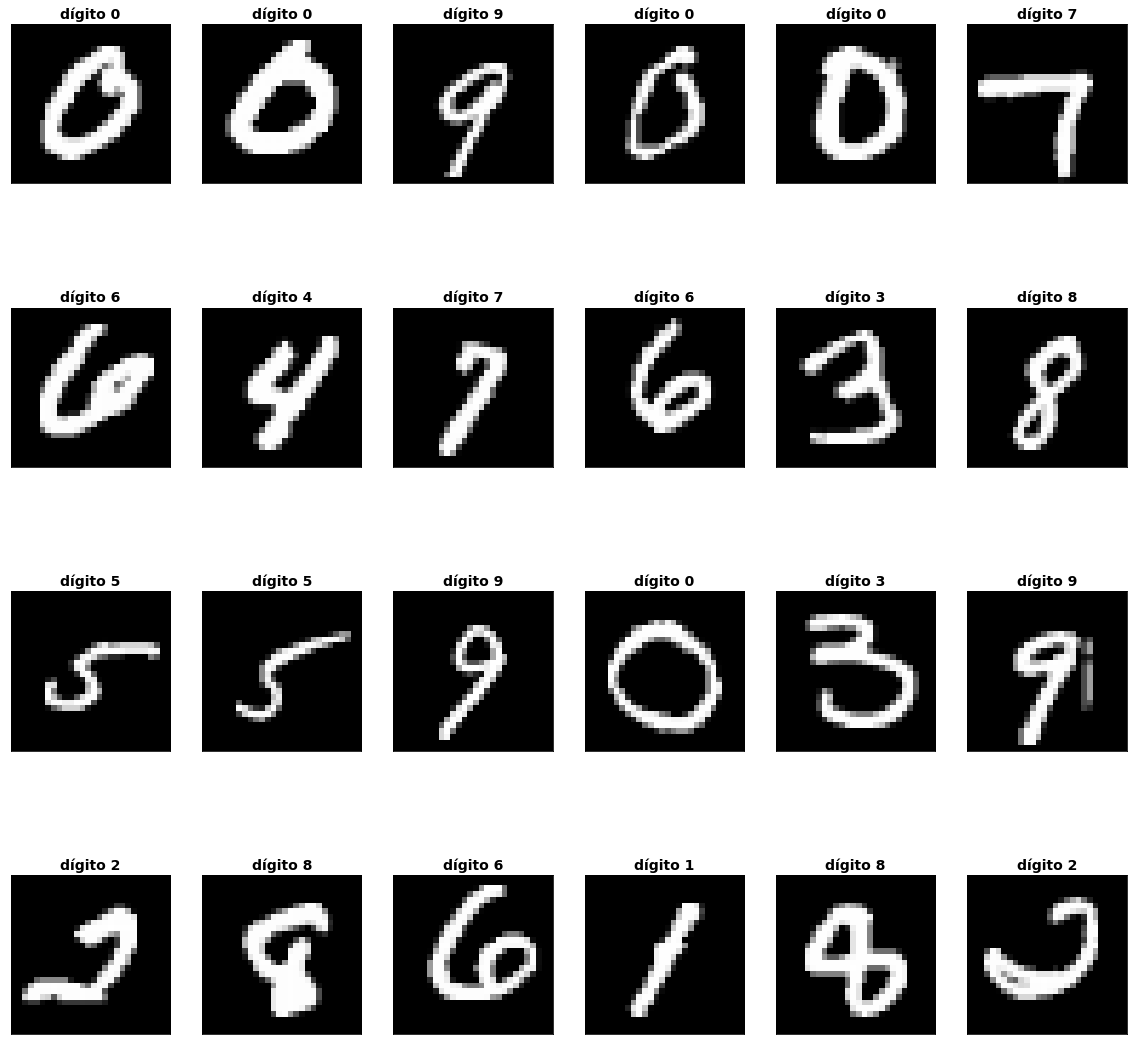

In [6]:
random_idx = np.random.randint(0,X.shape[0], size = 24)

plt.figure(figsize=[20,20])
for i in range(len(random_idx)):
    idx_i = random_idx[i]
    xval = X[idx_i, :].reshape(28,28)
    yval = y[idx_i]
    plt.subplot(4,6,i+1)
    plt.imshow(xval, cmap = plt.cm.Greys_r)
    plt.xticks([])
    plt.yticks([])
    plt.title("dígito "+str(int(yval)), fontsize = 14, fontweight = 'bold')

# Classificação binaria:<br>
-Irá valer 1 se o digito for Par;

-Irá valer 0 se o digito for impar

## Definindo Valores Pares e Impares

In [7]:
#SE O RESTO DA DIVISÃO FOR ZERO É PAR(NUM 1)
#SE O RESTO DA DIVISÃO FOR DIFERENTE DE ZERO É IMPAR(NUM 0)

ytrain = np.where(ytrain %2 == 0, 1, 0)
ytest = np.where(ytest %2 == 0, 1, 0)

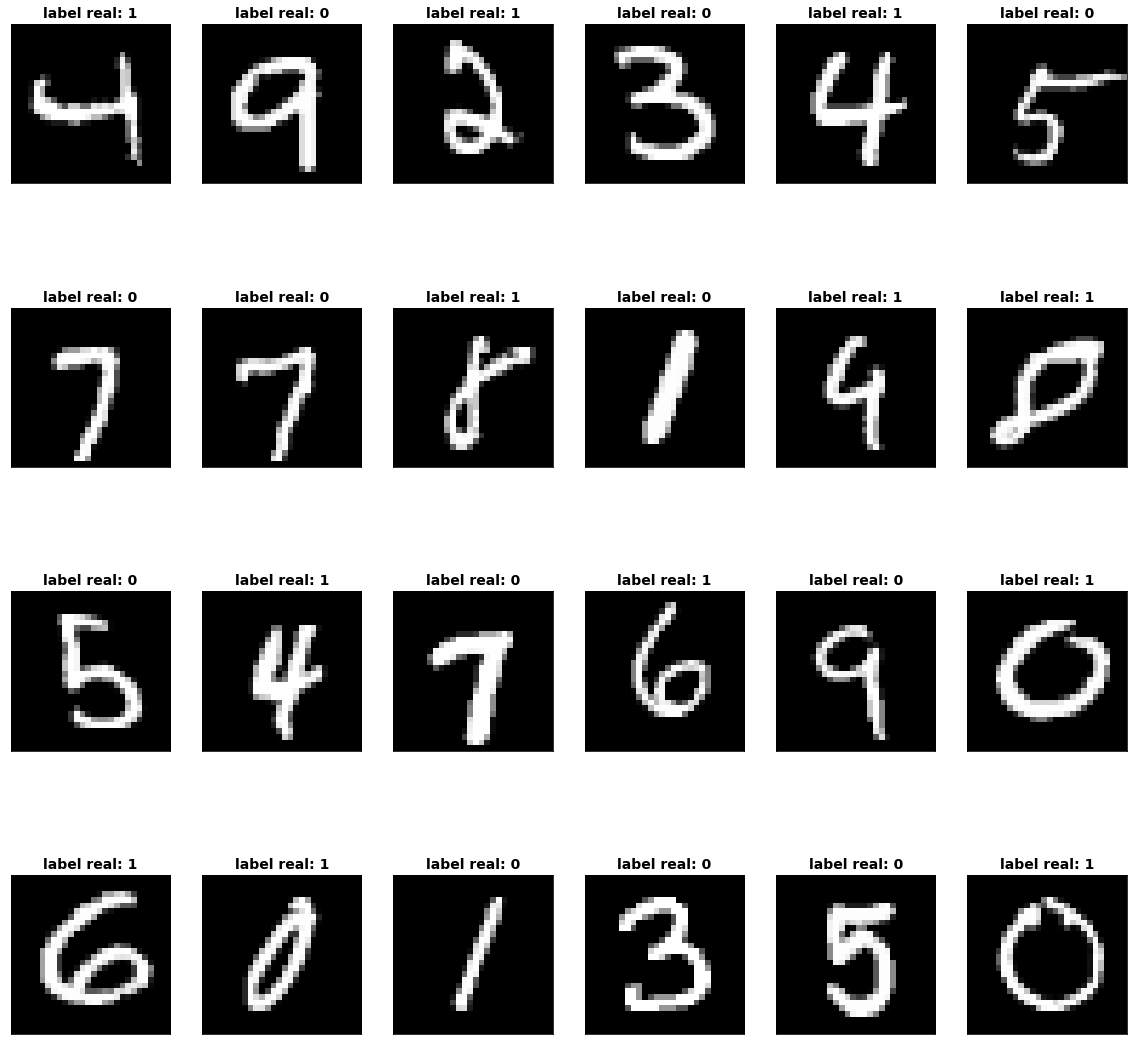

In [8]:
random_idx = np.random.randint(0,Xtrain.shape[0], size = 24)

plt.figure(figsize=[20,20])
for i in range(len(random_idx)):
    idx_i = random_idx[i]
    xval = Xtrain[idx_i, :].reshape(28,28)
    yval = ytrain[idx_i]
    plt.subplot(4,6,i+1)
    plt.imshow(xval, cmap = plt.cm.Greys_r)
    plt.xticks([])
    plt.yticks([])
    plt.title("label real: "+str(yval), fontsize = 14, fontweight = 'bold')
plt.show()

In [9]:
print('Percentual de numeros Pares: ',(ytrain.sum() / ytrain.size) * 100, '%')
print('Percentual de numeros Impares: ',((ytrain.size-ytrain.sum()) / ytrain.size) * 100, '%')

Percentual de numeros Pares:  49.154545454545456 %
Percentual de numeros Impares:  50.84545454545455 %


## Conclusão dos Valores:

Neste Caso, os valores pares (numero 1, classe __positiva__) e os valores impares (numero zero, classe __negativa__) estão balanceados, Pois a diferença entre eles são de 1 %.

# Importando Bibliotecas de Machine Learning

In [10]:
from sklearn.metrics import roc_auc_score

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve

In [12]:
#Validação Cruzada
from sklearn.model_selection import KFold

## Implementação Manual da Validação Cruzada
Onde:<br>


*   Classificador: Tipo do modelo de Machine Learning
*   X : Variveis Indenpendentes
*   y : Variavel Depedente
*   metrica: metrica de performance do modelo (neste caso setado para roc_auc_score)
*   limiar: trashhold para decisão de valores positivos e negativos
*   print_info: se True, imprime o resultado no output.
*   nome_metrica: nome da metrica para aparecer no texto do output



In [13]:
def validacao_cruzada(classificador, 
                      X, 
                      y, 
                      metrica, 
                      num_folds, 
                      limiar = 0.5, 
                      print_info = False, 
                      nome_metrica = None):
    
    lista_metrica_treino = []
    lista_metrica_validacao = []
    kf = KFold(n_splits = num_folds)
    for train_index, val_index in kf.split(X, y):
        Xtrain_folds = X[train_index]
        ytrain_folds = y[train_index]
        Xval_fold = X[val_index]
        yval_fold = y[val_index]
        classificador.fit(Xtrain_folds, ytrain_folds)
        
        prob_class1_treino = classificador.predict_proba(Xtrain_folds)[:,1]
        prob_class1_validacao = classificador.predict_proba(Xval_fold)[:,1]
        pred_treino = np.where(prob_class1_treino > limiar, 1, 0)
        pred_validacao = np.where(prob_class1_validacao > limiar, 1, 0)
        
        lista_metrica_treino.append(metrica(y_score = pred_treino, y_true = ytrain_folds))
        lista_metrica_validacao.append(metrica(y_score = pred_validacao, y_true = yval_fold))

        fpr, tpr, thresholds = roc_curve(y_true = ytrain_folds, y_score = pred_treino)
    if print_info:
        print("Métrica: " + nome_metrica)
        print('média treino:', np.mean(lista_metrica_treino))
        print('média validação:', np.mean(lista_metrica_validacao))
        print("")
        plt.figure(figsize=[8,6])
        plt.plot(fpr, tpr, c = 'blue', lw = 2)
        plt.title("Curva ROC (dataset de teste)", fontsize = 16, fontweight = 'bold')
        plt.xlabel("taxa de falso positivos", fontsize = 14, fontweight = 'bold')
        plt.ylabel("taxa de verdadeiro positivos", fontsize = 14, fontweight = 'bold')
        plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
        plt.grid()
        plt.show()

    return lista_metrica_treino, lista_metrica_validacao

# Testando a Função Validação Cruzada:

## Regressão Logistica

Regressão Logistica - Testando o limiar 0.15:
Métrica: AUC
média treino: 0.8363164692110615
média validação: 0.8325649492025973



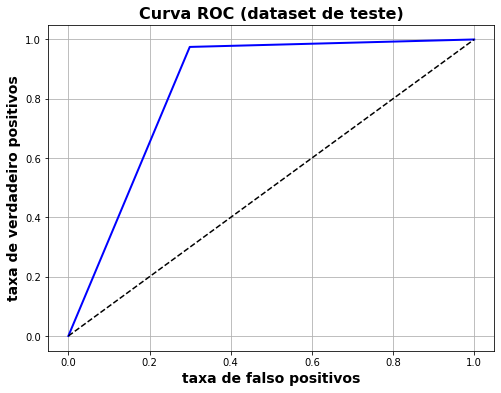

In [14]:
print("Regressão Logistica - Testando o limiar 0.15:")
lt, lv = validacao_cruzada(classificador = LogisticRegression(), 
                           X = Xtrain, 
                           y = ytrain, 
                           metrica = roc_auc_score,
                           num_folds = 5, 
                           limiar = 0.15,
                           print_info = True, 
                           nome_metrica = 'AUC')

## KNN

KNN - Testando o limiar 0.3:
Métrica: KNN
média treino: 0.9893358191192447
média validação: 0.9829861740133554



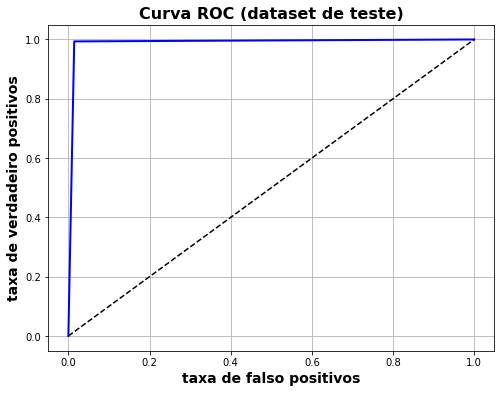

In [15]:
print("KNN - Testando o limiar 0.3:")
lt, lv = validacao_cruzada(classificador = KNeighborsClassifier(n_neighbors=5), 
                           X = Xtrain, 
                           y = ytrain, 
                           metrica = roc_auc_score,
                           num_folds = 5, 
                           limiar = 0.3,
                           print_info = True, 
                           nome_metrica = 'KNN')

Testando o limiar 0.5:
Métrica: KNN
média treino: 0.9884665420892667
média validação: 0.9814113455817666


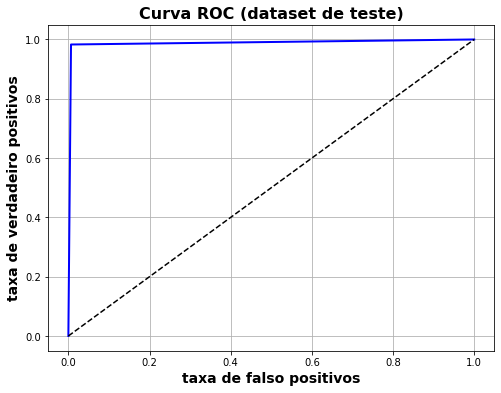

In [ ]:
print("KNN - Testando o limiar 0.5:")
lt, lv = validacao_cruzada(classificador = KNeighborsClassifier(n_neighbors=5), 
                           X = Xtrain, 
                           y = ytrain, 
                           metrica = roc_auc_score,
                           num_folds = 5, 
                           limiar = 0.5,
                           print_info = True, 
                           nome_metrica = 'KNN')

KNN - Testando o limiar 0.5:
Métrica: KNN
média treino: 0.9916537147189309
média validação: 0.9822978646977685


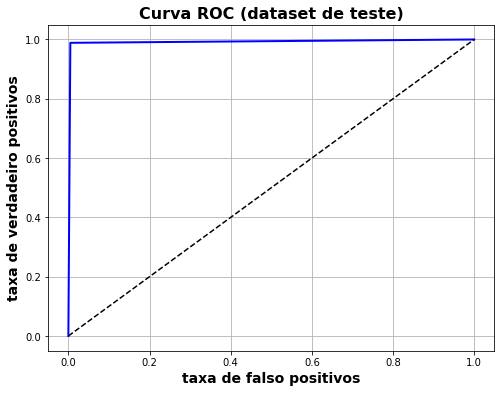

In [ ]:
print("KNN - Testando o limiar 0.5:")
lt, lv = validacao_cruzada(classificador = KNeighborsClassifier(n_neighbors=3), 
                           X = Xtrain, 
                           y = ytrain, 
                           metrica = roc_auc_score,
                           num_folds = 5, 
                           limiar = 0.5,
                           print_info = True, 
                           nome_metrica = 'KNN')

# Buscando o Melhor Limiar:

## Regressão Logistica

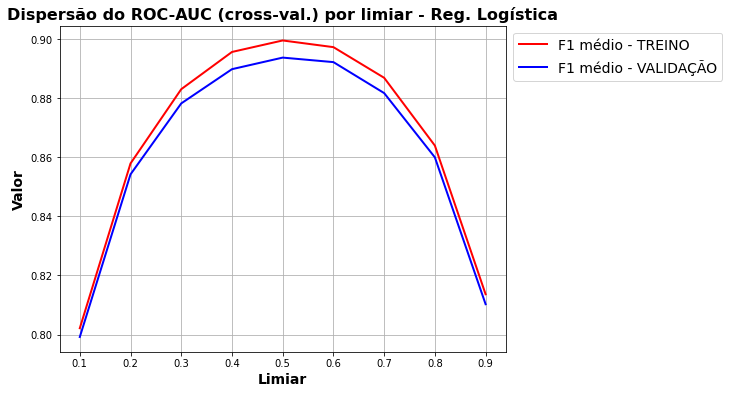

In [ ]:
limiares = np.arange(0.1 , 1, 0.1)

lista_media_metrica_treino = []
lista_media_metrica_validacao = []

for t in limiares:
  lt, lv = validacao_cruzada(classificador = LogisticRegression(), 
                                X = Xtrain, 
                                y = ytrain, 
                                metrica = roc_auc_score,
                                num_folds = 5, 
                                limiar = t)
    
  lista_media_metrica_treino.append(np.mean(lt))
  lista_media_metrica_validacao.append(np.mean(lv))
    
plt.figure(figsize=[8,6])
plt.plot(range(len(limiares)), lista_media_metrica_treino, c = 'red', label = 'ROC-AUC Médio - TREINO', lw = 2)
plt.plot(range(len(limiares)), lista_media_metrica_validacao, c = 'blue', label = 'ROC-AUC Médio - VALIDAÇÃO', lw = 2)
plt.xticks(range(len(limiares)), limiares.round(2))
plt.legend(fontsize = 14, bbox_to_anchor = [1,1])
plt.grid()
plt.xlabel("Limiar", fontsize = 14, fontweight = 'bold')
plt.ylabel("Valor", fontsize = 14, fontweight = 'bold') 
plt.title("Dispersão do ROC-AUC (cross-val.) por limiar - Reg. Logística", fontsize = 16, fontweight = 'bold')
plt.show()
 

# Conclusão da Escolha do Limiar:

OBS: o melhor limiar do KNN foi Escolhido para 0.3, o algoritmo de busca teve um tempo de processamento muito alto, inicialmente possuia valores de 0.1 até 0.9 espaçados em 0.1, devido a isso ficou rodando por 2 horas, e não apresentou resultados.

*   __Melhor Limiar para Regressão Logistica: 0.5__
*   __Melhor Limiar para KNN: 0.3__



# Utilizando o Melhor Limiar:

## Regresão Logistica

Regressão Logistica - limiar 0.5:
Métrica: ROC-AUC
média treino: 0.8995727103066751
média validação: 0.8937691797034161


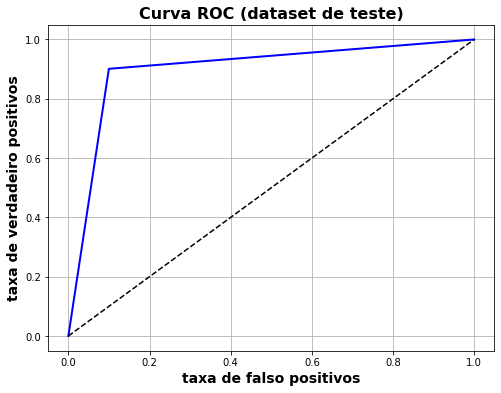

In [ ]:
print("Regressão Logistica - limiar 0.5:")
lt, lv = validacao_cruzada(classificador = LogisticRegression(), 
                           X = Xtrain, 
                           y = ytrain, 
                           metrica = roc_auc_score,
                           num_folds = 5, 
                           limiar = 0.5,
                           print_info = True, 
                           nome_metrica = 'ROC-AUC')

## KNN 

O Melhor Limiar foi o para KNN = 5 Vizinhos; e 0.3 de Limiar